# 📊 Portfolio Optimization Using Modern Portfolio Theory (MPT)


## 1. 🧭 Introduction and Objective
- Overview of portfolio theory
- Goal: Optimize asset weights to maximize risk-adjusted return

## 2. 📥 Data Acquisition
- Downloading historical price data using Yahoo Finance

## 3. 📈 Return Calculations and Risk Measures
- Log returns
- Annualized mean returns and covariance matrix

## 4. 🔍 Portfolio Performance Metrics
- Function to calculate return, volatility, and Sharpe ratio

## 5. 📐 Portfolio Optimization (Max Sharpe)
- Optimization using scipy's SLSQP solver
- Constraints: No shorting, weights sum to 1

## 6. 🌈 Efficient Frontier Visualization
- 5000 random portfolios
- Color-coded by Sharpe ratio
- Highlight optimal portfolio

## 7. 📋 Optimal Portfolio Summary
- Weights table
- Expected return, risk, and Sharpe ratio

## 8. 📉 Additional Risk Metrics
- Sortino Ratio
- Maximum Drawdown

## 9. 📊 Rolling Sharpe Ratio
- Visualization of 1-year rolling Sharpe for temporal stability

## 10. 🎲 Monte Carlo Simulation of Portfolio Value
- Simulated price paths for 1 year based on historical returns

## 11. 🧠 Diversification Check via PCA
- Cumulative explained variance to assess correlation structure

## 12. 🏦 CAPM Analysis vs S&P 500
- Estimate alpha and beta using linear regression

## 13. 📤 Exporting Results
- Save weights and metrics to CSV for reporting

## 14. 🧾 Conclusion and Insights
- Final summary
- Limitations and possible improvements (e.g. Black-Litterman, HRP)


[*********************100%***********************]  8 of 8 completed


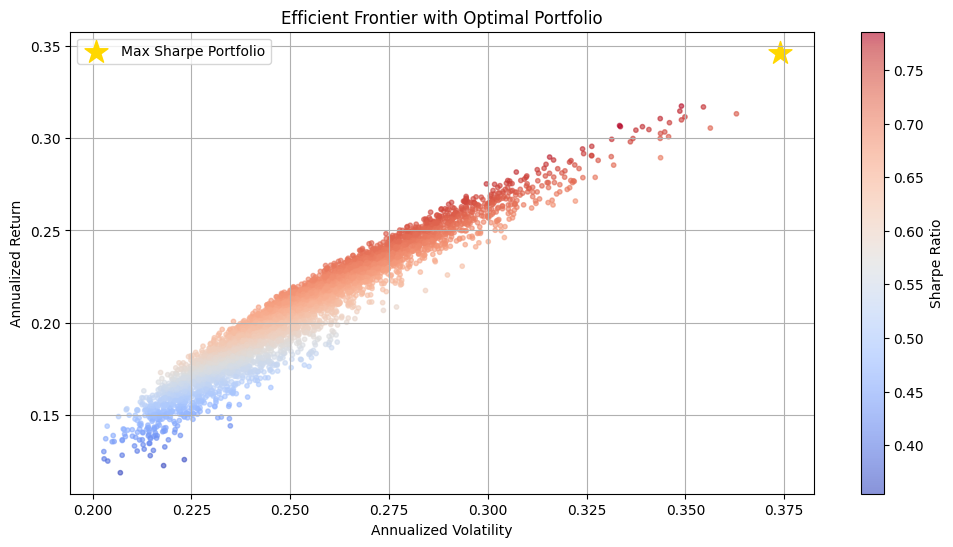

🔎 Optimal Portfolio Weights:
   Stock  Weight
0   AAPL  48.59%
1   MSFT   0.00%
2  GOOGL   6.51%
3   AMZN   0.00%
4    JNJ   0.00%
5    JPM   0.00%
6    XOM  37.71%
7   TSLA   7.19%

📌 Expected Annual Return: 34.65%
📌 Annual Volatility: 37.40%
📌 Sharpe Ratio: 0.81
📉 Sortino Ratio: 1.56
📉 Max Drawdown: -46.61%


In [5]:
# 1. Install necessary libraries (if not already installed)
!pip install yfinance --quiet

# 2. Import required libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 3. Fetch historical data for selected stocks
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'JNJ', 'JPM', 'XOM', 'TSLA']
start_date = '2020-01-01'
end_date = '2024-12-31'

data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']
data = data.dropna()

# 4. Calculate log returns and statistics
returns = np.log(data / data.shift(1)).dropna()
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252
rf_rate = 0.045  # Annual risk-free rate (approx 4.5%)

# 5. Helper: Portfolio metrics
def portfolio_performance(weights, mean_returns, cov_matrix, rf_rate):
    weights = np.array(weights)
    port_return = np.dot(weights, mean_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = (port_return - rf_rate) / port_vol
    return port_return, port_vol, sharpe

# 6. Objective: Maximize Sharpe (negated)
def neg_sharpe(weights, mean_returns, cov_matrix, rf_rate):
    return -portfolio_performance(weights, mean_returns, cov_matrix, rf_rate)[2]

# 7. Constraints and bounds
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # weights sum to 1
bounds = tuple((0, 1) for _ in range(len(tickers)))  # no shorting

# 8. Optimization
initial_guess = len(tickers) * [1. / len(tickers)]
opt_results = minimize(neg_sharpe, initial_guess, method='SLSQP', bounds=bounds, constraints=constraints, args=(mean_returns, cov_matrix, rf_rate))

# 9. Extract optimal portfolio
opt_weights = opt_results.x
opt_ret, opt_vol, opt_sharpe = portfolio_performance(opt_weights, mean_returns, cov_matrix, rf_rate)

# 10. Build Efficient Frontier
num_portfolios = 5000
results = np.zeros((3, num_portfolios))
weights_record = []

for i in range(num_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)

    ret, vol, sharpe = portfolio_performance(weights, mean_returns, cov_matrix, rf_rate)
    results[0, i] = ret
    results[1, i] = vol
    results[2, i] = sharpe

# 11. Plot Efficient Frontier with Max Sharpe
plt.figure(figsize=(12, 6))
plt.scatter(results[1,:], results[0,:], c=results[2,:], cmap='coolwarm', s=10, alpha=0.6)
plt.colorbar(label='Sharpe Ratio')
plt.scatter(opt_vol, opt_ret, marker='*', color='gold', s=300, label='Max Sharpe Portfolio')
plt.title("Efficient Frontier with Optimal Portfolio")
plt.xlabel("Annualized Volatility")
plt.ylabel("Annualized Return")
plt.legend()
plt.grid(True)
plt.show()

# 12. Print Summary Table
summary = pd.DataFrame({
    'Stock': tickers,
    'Weight': [f"{w:.2%}" for w in opt_weights]
})
print("🔎 Optimal Portfolio Weights:")
print(summary)

print(f"\n📌 Expected Annual Return: {opt_ret:.2%}")
print(f"📌 Annual Volatility: {opt_vol:.2%}")
print(f"📌 Sharpe Ratio: {opt_sharpe:.2f}")

# 13. Optional: Risk Metrics (Sortino, Max Drawdown) - need daily returns for these
daily_returns = data.pct_change().dropna()

def sortino_ratio(returns_df, weights, rf_rate):
    # Ensure returns_df is a pandas DataFrame and weights is a numpy array
    if not isinstance(returns_df, pd.DataFrame):
        returns_df = pd.DataFrame(returns_df)
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)

    # Calculate daily portfolio returns
    daily_portfolio_returns = returns_df.dot(weights)

    downside_returns = daily_portfolio_returns[daily_portfolio_returns < 0]
    downside_std = np.std(downside_returns)

    # Annualize the risk-free rate to daily for the Sortino ratio calculation
    daily_rf_rate = (1 + rf_rate)**(1/252) - 1

    return (daily_portfolio_returns.mean() - daily_rf_rate) / downside_std * np.sqrt(252) if downside_std != 0 else np.nan


def max_drawdown(returns_df, weights):
    # Ensure returns_df is a pandas DataFrame and weights is a numpy array
    if not isinstance(returns_df, pd.DataFrame):
        returns_df = pd.DataFrame(returns_df)
    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)

    # Calculate daily portfolio returns
    daily_portfolio_returns = returns_df.dot(weights)

    cum_returns = (daily_portfolio_returns + 1).cumprod()
    cum_max = cum_returns.cummax()
    drawdowns = (cum_returns - cum_max) / cum_max
    return drawdowns.min()


sortino = sortino_ratio(daily_returns, opt_weights, rf_rate)
mdd = max_drawdown(daily_returns, opt_weights)

print(f"📉 Sortino Ratio: {sortino:.2f}")
print(f"📉 Max Drawdown: {mdd:.2%}")

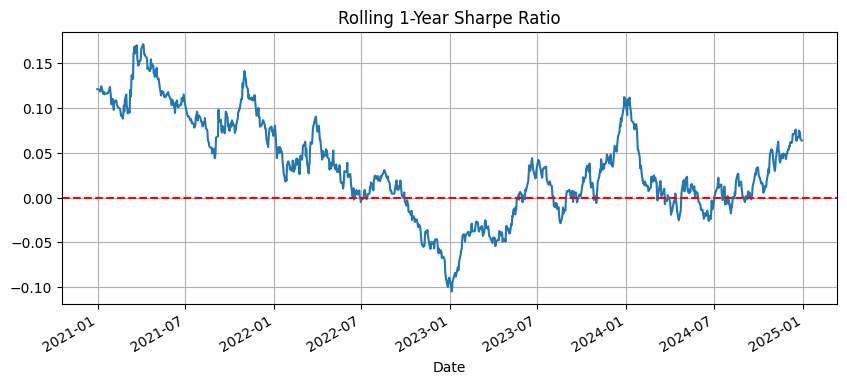

In [6]:
rolling_returns = (returns @ opt_weights)
rolling_sharpe = (rolling_returns.rolling(252).mean() - rf_rate/252) / rolling_returns.rolling(252).std()

plt.figure(figsize=(10, 4))
rolling_sharpe.plot()
plt.title("Rolling 1-Year Sharpe Ratio")
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()


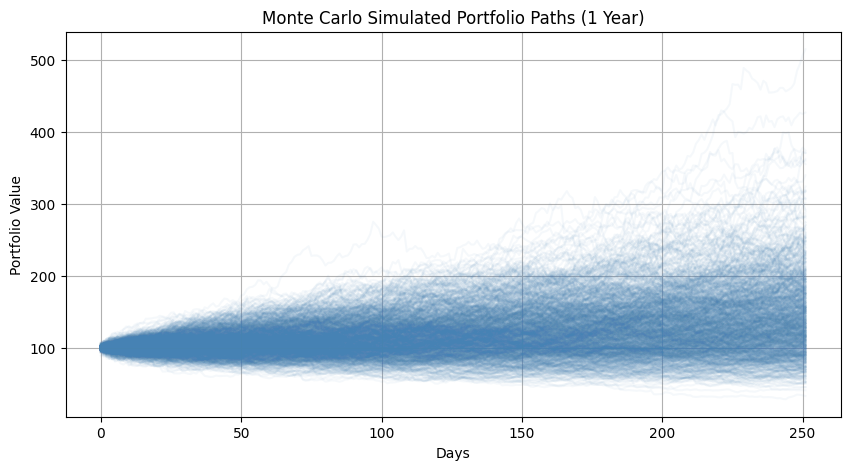

In [7]:
sim_days = 252
simulations = 1000
daily_returns = (returns @ opt_weights).dropna()

last_price = 100
simulated_paths = np.zeros((sim_days, simulations))

for i in range(simulations):
    rand_returns = np.random.choice(daily_returns, size=sim_days, replace=True)
    price_path = [last_price]
    for ret in rand_returns:
        price_path.append(price_path[-1] * (1 + ret))
    simulated_paths[:, i] = price_path[1:]

plt.figure(figsize=(10, 5))
plt.plot(simulated_paths, alpha=0.05, color='steelblue')
plt.title("Monte Carlo Simulated Portfolio Paths (1 Year)")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()


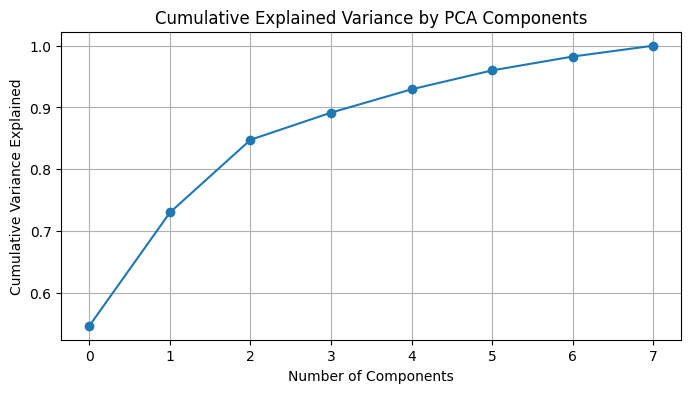

In [8]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(returns)

explained_var = pca.explained_variance_ratio_

plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(explained_var), marker='o')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.grid(True)
plt.show()


In [10]:
benchmark = yf.download('^GSPC', start="2020-01-01", end="2024-12-31")['Close']
benchmark_returns = np.log(benchmark / benchmark.shift(1)).dropna()
portfolio_returns = returns @ opt_weights
aligned = pd.concat([portfolio_returns, benchmark_returns], axis=1).dropna()
aligned.columns = ['Portfolio', 'Benchmark']

import statsmodels.api as sm
X = sm.add_constant(aligned['Benchmark'])
model = sm.OLS(aligned['Portfolio'], X).fit()
print(model.summary())

/tmp/ipython-input-10-4101675543.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  benchmark = yf.download('^GSPC', start="2020-01-01", end="2024-12-31")['Close']
[*********************100%***********************]  1 of 1 completed


                            OLS Regression Results                            
Dep. Variable:              Portfolio   R-squared:                       0.558
Model:                            OLS   Adj. R-squared:                  0.558
Method:                 Least Squares   F-statistic:                     1586.
Date:                Sat, 12 Jul 2025   Prob (F-statistic):          7.33e-225
Time:                        03:21:06   Log-Likelihood:                 3439.6
No. Observations:                1256   AIC:                            -6875.
Df Residuals:                    1254   BIC:                            -6865.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.713      0.0